In [2]:
#Package Imports
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import datetime

#tensorflow inputs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

env_name = "CartPole-v1"

In [3]:
#Setup Policy NN

class REINFORCE_solver:
    
    def __init__(self, observation_space, action_space, log_dir):
        
        #Solver parameters
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.action_space = action_space
        
        #writer for tensorboard
        self.summary_writer = tf.summary.FileWriter(log_dir)
        
        #NN parameters
        #1 hidden layer NN      
        self.model = Sequential()
        self.model.add(Dense(12, input_shape=(observation_space,), activation="relu", name="input"))
        self.model.add(Dense(12, activation="relu", name="hidden"))
        self.model.add(Dense(self.action_space, activation="softmax", name="output"))
        self.model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        print(self.model.summary())
        
    def act(self, state):
        #compute the action probabilities from the model
        probs = (self.model.predict(state)).squeeze()
        #compute an action from the probabilities
        action = np.random.choice(self.action_space, p = probs)
        #compute the log of the probability of the chosen action
        log_prob = np.log(probs[action])
        return action, log_prob
    
    def act_validation(self, state):
        #take the action with the highest probability
        probs = (self.model.predict(state)).squeeze()
        action = np.argmax(probs)
        return action
        
    def update_policy(self, log_probs, rewards, states, actions):
        
        #compute discounted rewards:
        disc_rewards = []
        
        for i in range(0, len(rewards)):
            R_t = 0
            exponent = 0
            for r in rewards[i:]:
                R_t += self.gamma **  exponent * r
                exponent += 1
            disc_rewards.append(R_t)
            
        #normalize discounted rewards
        disc_rewards = np.asarray(disc_rewards)
        disc_rewards = (disc_rewards - disc_rewards.mean()) / (disc_rewards.std())
        
        #compute the loss function
        policy_grad = []
        for log_prob, R_t in zip(log_probs, disc_rewards):
            policy_grad.append(-log_prob * R_t)
            
        #update the model
        advantage = np.zeros((len(states), self.action_space))
                
        for i in range(0, len(states)):
            advantage[i][actions[i]] = policy_grad[i]
        loss = self.model.fit(np.asarray(states).squeeze(), advantage, verbose=0)
        return loss

In [5]:
#Solve cartpole
    
#problem solved condition
num_ticks_to_win = 195

scores = []
score_list = []
mean_score_list = []
num_trials = -1

losses = []

verbose = True

#max number of episodes
max_episodes = 10000

#training environment - exploration policy
env = gym.make(env_name)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

#validation environment - greedy policy
env_validation = gym.make(env_name)

#directory for logfiles (tensorboard)
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

reinforce_solver = REINFORCE_solver(observation_space, action_space, log_dir)

for episode in range(0, max_episodes):
    states = []
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    states.append(state)
    
    actions = []
    
    log_probs = []
    rewards = []
    
    done = False
    step = 0
    while not done:
        #rollout with present policy
        step += 1
        #compute the action for the present state
        action, log_prob = reinforce_solver.act(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        #advance the environment
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, observation_space])
        states.append(next_state)
        rewards.append(reward)
        
        state = next_state
    states.pop()
    
    #Validation Policy
    state = env_validation.reset()
    state = np.reshape(state, [1, observation_space])
    done_validation = False
    step = 0
    while not done_validation:
        step += 1
        #compute the greedy action for the present state
        action = reinforce_solver.act_validation(state)
        
        #advance the environment
        next_state, reward, done_validation, info = env_validation.step(action)
        next_state = np.reshape(next_state, [1, observation_space])
        state = next_state
    
    #number of steps the pole was upright
    scores.append(step)
    #dqn_solver.log_results('scores', step, episode)

    mean_score = np.mean(scores)
    #dqn_solver.log_results('mean_score(100)', mean_score, episode)

    #score_list.append(step)
    mean_score_list.append(mean_score)

    if mean_score >= num_ticks_to_win and episode >= 100:
        if verbose:
            print('Ran {} episodes. Solved after {} trials'.format(episode, episode - 100))
        num_trials = episode - 100
        break
        
    if verbose and episode % 100 == 0:
        print('[Episode {}] - Mean survival time over last 100 episodes was {}.'.format(episode, mean_score))
    
    loss = reinforce_solver.update_policy(log_probs, rewards, states, actions)
    losses.append(loss)
    
print("Program Complete")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 12)                60        
_________________________________________________________________
hidden (Dense)               (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 2)                 26        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
None
[Episode 0] - Mean survival time over last 100 episodes was 10.0.
[Episode 100] - Mean survival time over last 100 episodes was 53.475247524752476.
[Episode 200] - Mean survival time over last 100 episodes was 106.8457711442786.
[Episode 300] - Mean survival time over last 100 episodes was 143.71428571428572.
[Episode 400] - Mean survival time over last 100 episodes was 175.57356608478804.
Ran 460 ep

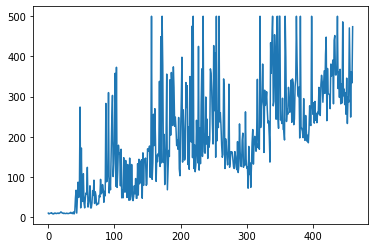

In [6]:
plt.plot(scores)

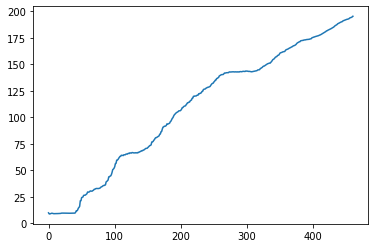

In [7]:
plt.plot(mean_score_list)